In [1]:
!pip install keras-tcn
!pip install keras-tcn --no-dependencies

     |████████████████████████████████| 706kB 5.1MB/s 


In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np

import keras 
import pandas as pd


from keras.models import Sequential
from keras.layers import Dense 

from keras.layers import Dropout

from keras.layers import LSTM

from keras.layers import *


from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping


from keras.layers import Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D



from keras.layers import Dense, Embedding, LSTM, Bidirectional
from tcn import TCN, tcn_full_summary

DATA

In [3]:
df=pd.read_csv("FB.csv")
print("Number of rows and columns:", df.shape)
df.head(5)
training_set = df.iloc[:1052, 4:5].values

test_set = df.iloc[1052:, 4:5].values
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1052):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],  X_train.shape[1], 1, 1))
X_train.shape

Number of rows and columns: (1503, 7)


(992, 60, 1, 1)

TCN Model

In [4]:
dataset_train = df.iloc[:1052, 4:5]
dataset_test = df.iloc[1052:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
X_test = []
for i in range(60, 511):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

y =  dataset_test.values.reshape(451,) 
# (459, 60, 1)

(511, 1)
(451, 60, 1)


In [ ]:
np.random.seed(1)
model = Sequential()
model.add(TCN(nb_filters=64, kernel_size=4, nb_stacks=1, dilations=[1, 2, 4, 8, 16 ], padding='causal', use_skip_connections=False, dropout_rate=0.0, return_sequences=False, activation='relu', input_shape = (X_train.shape[1], 1)))
#model.add(Dropout(0.1))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
31/31 [==============================] - 2s 8ms/step - loss: 18.6274
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.1076
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0193
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0028
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 11/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 12/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 13/100
31/31 [================

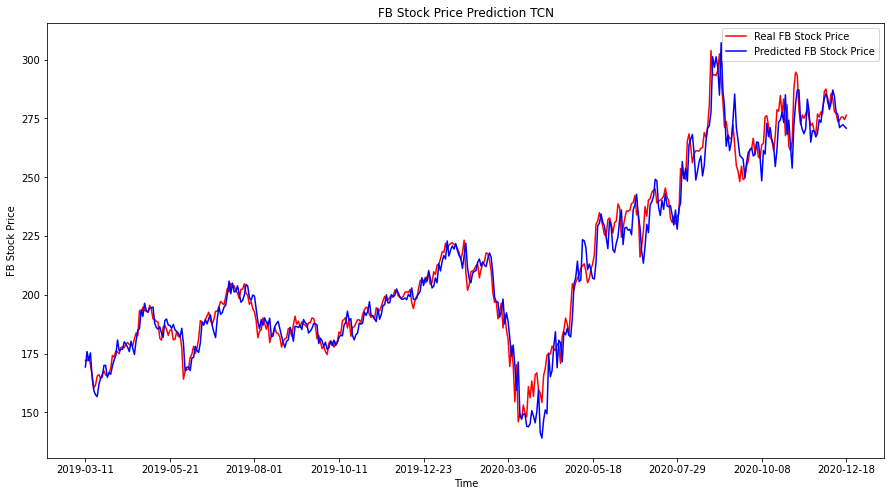

<Figure size 432x288 with 0 Axes>

In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real FB Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted FB Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('FB Stock Price Prediction TCN')
plt.xlabel('Time')
plt.ylabel('FB Stock Price')
plt.legend()
plt.show() 
plt.savefig("FB CNN LSTM")

In [ ]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

4.782464117969183

In [ ]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

6.6671455659458045

TCN + GRU

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, 200)          121800      input_1[0][0]                    
__________________________________________________________________________________________________
tcn (TCN)                       (None, 64)           185408      input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1)            201         gru[0][0]                        
______________________________________________________________________________________________

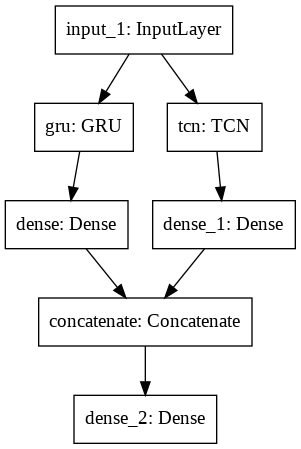

In [5]:
np.random.seed(1)


from keras.layers import Input
from keras.utils import plot_model
from keras.layers.merge import concatenate
from keras.models import Model

visible = Input(shape=(60,1))

#GRU
gru1 = GRU(units = 200, input_shape = (X_train.shape[1], 1))(visible)
out1 = Dense(units = 1)(gru1)

#TCN
tcn1 = TCN(nb_filters=64, kernel_size=5, nb_stacks=1, dilations=[1, 2, 4, 8, 16 ], padding='causal', use_skip_connections=False, dropout_rate=0, return_sequences=False, activation='relu', input_shape = (X_train.shape[1], 1))(visible)
out2 = Dense(units = 1)(tcn1)

# merge interpretation
merge = concatenate([out1, out2])

# output
output = Dense(1)(merge)
model = Model(inputs=visible, outputs=output)

# summarize layers
print(model.summary())

# plot graph
plot_model(model, to_file='shared_feature_extractor.png')

In [9]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 3s 13ms/step - loss: 0.0111
Epoch 2/30
31/31 [==============================] - 0s 12ms/step - loss: 6.9117e-04
Epoch 3/30
31/31 [==============================] - 0s 12ms/step - loss: 5.4009e-04
Epoch 4/30
31/31 [==============================] - 0s 12ms/step - loss: 3.7826e-04
Epoch 5/30
31/31 [==============================] - 0s 12ms/step - loss: 3.9310e-04
Epoch 6/30
31/31 [==============================] - 0s 12ms/step - loss: 2.9183e-04
Epoch 7/30
31/31 [==============================] - 0s 12ms/step - loss: 3.3654e-04
Epoch 8/30
31/31 [==============================] - 0s 12ms/step - loss: 3.3701e-04
Epoch 9/30
31/31 [==============================] - 0s 12ms/step - loss: 3.9355e-04
Epoch 10/30
31/31 [==============================] - 0s 12ms/step - loss: 8.0676e-04
Epoch 11/30
31/31 [==============================] - 0s 11ms/step - loss: 2.9566e-04
Epoch 12/30
31/31 [==============================] - 0s 12ms/step - loss: 2.80

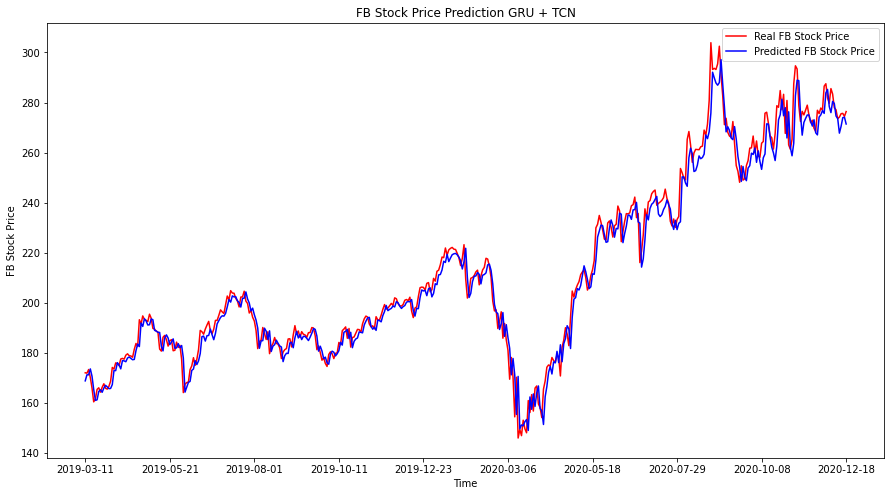

<Figure size 432x288 with 0 Axes>

In [10]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real FB Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted FB Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('FB Stock Price Prediction GRU + TCN')
plt.xlabel('Time')
plt.ylabel('FB Stock Price')
plt.legend()
plt.show() 
plt.savefig("FB GRU + TCN")

In [11]:
abse = mean_absolute_error(predicted_stock_price,y)
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
print(abse, rmse)

3.9405423128789314 5.524610577286088


CNN LSTM MODEL

In [ ]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:1052, 4:5]
dataset_test = df.iloc[1052:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
X_test = []
for i in range(60, 511):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1, 1))
print(X_test.shape)

y =  dataset_test.values.reshape(451,) 


(511, 1)
(451, 60, 1, 1)


In [ ]:
np.random.seed(1)

model = Sequential()

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape = (X_train.shape[1],1, 1)))

model.add(TimeDistributed(MaxPooling1D(pool_size=1)))

model.add(TimeDistributed(Flatten()))

model.add(GRU(units = 700)) #, return_sequences = True

model.add(Dropout(0.1))


model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 8s 15ms/step - loss: 0.0403
Epoch 2/30
31/31 [==============================] - 0s 11ms/step - loss: 5.4495e-04
Epoch 3/30
31/31 [==============================] - 0s 11ms/step - loss: 5.4229e-04
Epoch 4/30
31/31 [==============================] - 0s 11ms/step - loss: 6.0969e-04
Epoch 5/30
31/31 [==============================] - 0s 11ms/step - loss: 6.4209e-04
Epoch 6/30
31/31 [==============================] - 0s 11ms/step - loss: 5.4421e-04
Epoch 7/30
31/31 [==============================] - 0s 11ms/step - loss: 6.0909e-04
Epoch 8/30
31/31 [==============================] - 0s 11ms/step - loss: 6.3608e-04
Epoch 9/30
31/31 [==============================] - 0s 11ms/step - loss: 6.1217e-04
Epoch 10/30
31/31 [==============================] - 0s 11ms/step - loss: 4.2741e-04
Epoch 11/30
31/31 [==============================] - 0s 11ms/step - loss: 5.3860e-04
Epoch 12/30
31/31 [==============================] - 0s 11ms/step - loss: 7.74

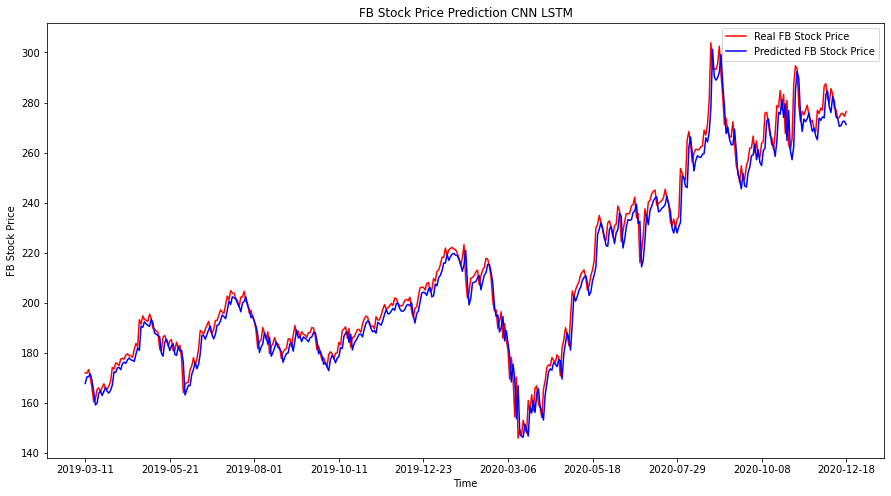

<Figure size 432x288 with 0 Axes>

In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real FB Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted FB Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('FB Stock Price Prediction CNN LSTM')
plt.xlabel('Time')
plt.ylabel('FB Stock Price')
plt.legend()
plt.show() 
plt.savefig("FB CNN LSTM")

In [ ]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

4.169721522870184

In [ ]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

5.599209591933301

CNN

In [ ]:
df=pd.read_csv("FB.csv")
print("Number of rows and columns:", df.shape)
df.head(5)
training_set = df.iloc[:1052, 4:5].values

test_set = df.iloc[1052:, 4:5].values
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1052):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1], 1))
X_train.shape

Number of rows and columns: (1503, 7)


(992, 1, 60, 1)

In [ ]:
np.random.seed(1)

model = Sequential()

model.add(TimeDistributed(Conv1D(filters=128, kernel_size=11, activation='relu'), input_shape = (1, X_train.shape[2],1)))
print(model.output_shape)
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
print(model.output_shape)
model.add(TimeDistributed(Flatten()))
print(model.output_shape)


model.add(Dense(units = 1))
print(model.output_shape)

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

(None, 1, 50, 128)
(None, 1, 25, 128)
(None, 1, 3200)
(None, 1, 1)
Epoch 1/30
31/31 [==============================] - 0s 1ms/step - loss: 0.0642
Epoch 2/30
31/31 [==============================] - 0s 1ms/step - loss: 0.0058
Epoch 3/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 4/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 5/30
31/31 [==============================] - 0s 1ms/step - loss: 0.0033
Epoch 6/30
31/31 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 7/30
31/31 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 8/30
31/31 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 9/30
31/31 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 10/30
31/31 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 11/30
31/31 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 12/30
31/31 [==============================] - 0s 1ms/st

In [ ]:

dataset_train = df.iloc[:1052, 4:5]
dataset_test = df.iloc[1052:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
X_test = []
for i in range(60, 511):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1],1))
print(X_test.shape)


(511, 1)
(451, 1, 60, 1)


In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(451,1)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

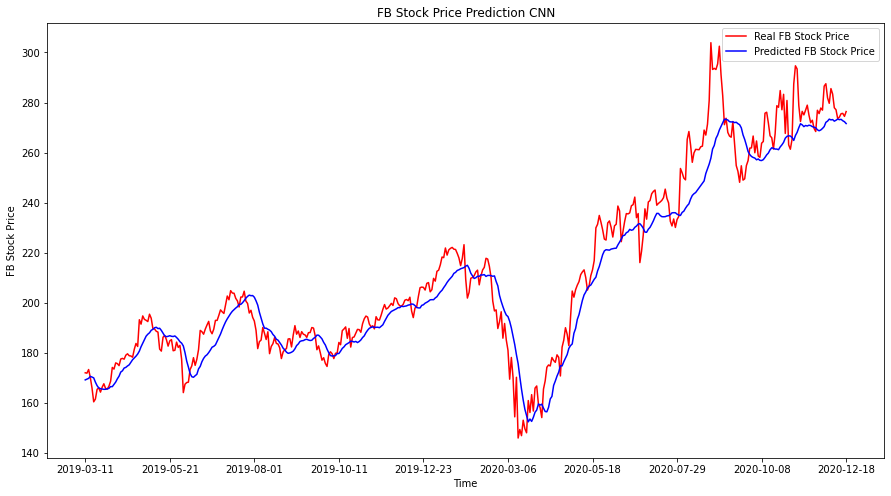

<Figure size 432x288 with 0 Axes>

In [ ]:

predicted_stock_price = model.predict(X_test).reshape(-1,1)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real FB Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted FB Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('FB Stock Price Prediction CNN')
plt.xlabel('Time')
plt.ylabel('FB Stock Price')
plt.legend()
plt.show() 
plt.savefig("FB CNN")

In [ ]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

7.595236455950751

In [ ]:
rmse=math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

9.998340413692684

LSTM GRU MODEL

In [ ]:

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1052):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],  X_train.shape[1], 1))
X_train.shape

(992, 60, 1)

In [ ]:
np.random.seed(1)
model = Sequential()
model.add(LSTM(units = 700, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(GRU(units = 700,  input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 3s 29ms/step - loss: 0.0331
Epoch 2/30
31/31 [==============================] - 1s 26ms/step - loss: 9.6885e-04
Epoch 3/30
31/31 [==============================] - 1s 26ms/step - loss: 9.3482e-04
Epoch 4/30
31/31 [==============================] - 1s 27ms/step - loss: 9.9372e-04
Epoch 5/30
31/31 [==============================] - 1s 26ms/step - loss: 0.0013
Epoch 6/30
31/31 [==============================] - 1s 26ms/step - loss: 0.0012
Epoch 7/30
31/31 [==============================] - 1s 27ms/step - loss: 8.5142e-04
Epoch 8/30
31/31 [==============================] - 1s 26ms/step - loss: 9.9951e-04
Epoch 9/30
31/31 [==============================] - 1s 27ms/step - loss: 8.4114e-04
Epoch 10/30
31/31 [==============================] - 1s 26ms/step - loss: 6.8852e-04
Epoch 11/30
31/31 [==============================] - 1s 27ms/step - loss: 6.8853e-04
Epoch 12/30
31/31 [==============================] - 1s 27ms/step - loss: 7.1279e-04
E

TEST DATA

In [ ]:

dataset_train = df.iloc[:1052, 4:5]
dataset_test = df.iloc[1052:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
X_test = []
for i in range(60, 511):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)


(511, 1)
(451, 60, 1)


PREDICTION

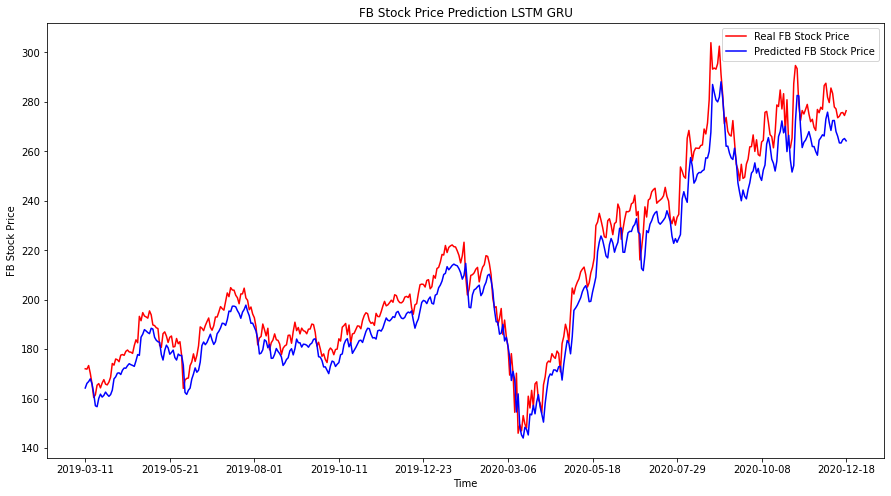

<Figure size 432x288 with 0 Axes>

In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real FB Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted FB Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('FB Stock Price Prediction LSTM GRU')
plt.xlabel('Time')
plt.ylabel('FB Stock Price')
plt.legend()
plt.show() 
plt.savefig("FB LSTM GRU")

In [ ]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

7.885363312746846

In [ ]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

9.19768945264872

LSTM Model

In [ ]:
model = Sequential()

model.add(LSTM(units = 700, input_shape = (X_train.shape[1], 1))) 
model.add(Dropout(0.1))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 1s 13ms/step - loss: 0.0952
Epoch 2/30
31/31 [==============================] - 0s 12ms/step - loss: 0.0039
Epoch 3/30
31/31 [==============================] - 0s 12ms/step - loss: 0.0014
Epoch 4/30
31/31 [==============================] - 0s 12ms/step - loss: 0.0012
Epoch 5/30
31/31 [==============================] - 0s 12ms/step - loss: 0.0013
Epoch 6/30
31/31 [==============================] - 0s 12ms/step - loss: 0.0011
Epoch 7/30
31/31 [==============================] - 0s 12ms/step - loss: 0.0012
Epoch 8/30
31/31 [==============================] - 0s 12ms/step - loss: 0.0010
Epoch 9/30
31/31 [==============================] - 0s 12ms/step - loss: 0.0011
Epoch 10/30
31/31 [==============================] - 0s 12ms/step - loss: 0.0011
Epoch 11/30
31/31 [==============================] - 0s 12ms/step - loss: 0.0013
Epoch 12/30
31/31 [==============================] - 0s 12ms/step - loss: 0.0016
Epoch 13/30
31/31 [==================

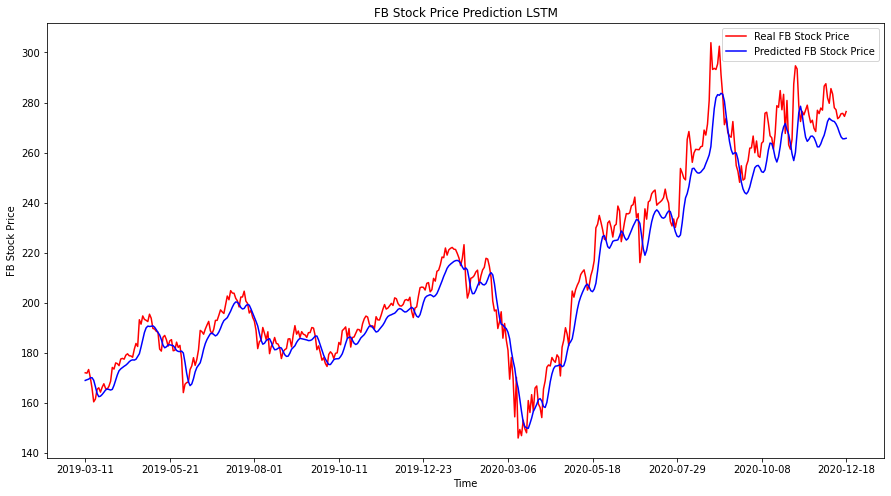

<Figure size 432x288 with 0 Axes>

In [ ]:
 predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real FB Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted FB Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('FB Stock Price Prediction LSTM')
plt.xlabel('Time')
plt.ylabel('FB Stock Price')
plt.legend()
plt.show() 
plt.savefig("FB LSTM")

In [ ]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

6.518688589947685

In [ ]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

8.532672128705322

RNN MODEL


In [ ]:
model = Sequential()

model.add(SimpleRNN(units = 700, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 30, batch_size = 32) 

Epoch 1/30
31/31 [==============================] - 1s 26ms/step - loss: 3.5556
Epoch 2/30
31/31 [==============================] - 1s 26ms/step - loss: 1.3160
Epoch 3/30
31/31 [==============================] - 1s 26ms/step - loss: 1.5640
Epoch 4/30
31/31 [==============================] - 1s 27ms/step - loss: 0.6161
Epoch 5/30
31/31 [==============================] - 1s 30ms/step - loss: 0.9639
Epoch 6/30
31/31 [==============================] - 1s 26ms/step - loss: 0.4248
Epoch 7/30
31/31 [==============================] - 1s 27ms/step - loss: 0.4521
Epoch 8/30
31/31 [==============================] - 1s 26ms/step - loss: 0.4575
Epoch 9/30
31/31 [==============================] - 1s 26ms/step - loss: 0.3892
Epoch 10/30
31/31 [==============================] - 1s 27ms/step - loss: 0.3641
Epoch 11/30
31/31 [==============================] - 1s 27ms/step - loss: 0.3510
Epoch 12/30
31/31 [==============================] - 1s 27ms/step - loss: 0.3188
Epoch 13/30
31/31 [==================

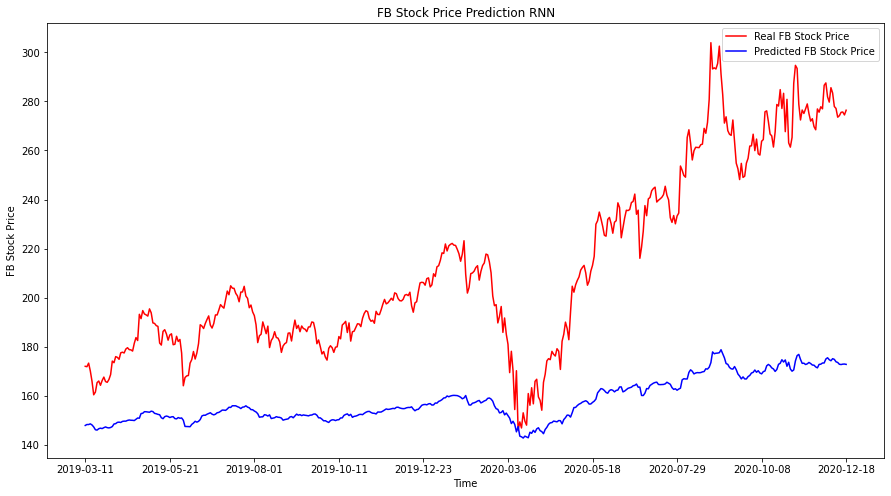

<Figure size 432x288 with 0 Axes>

In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real FB Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted FB Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('FB Stock Price Prediction RNN')
plt.xlabel('Time')
plt.ylabel('FB Stock Price')
plt.legend()
plt.show() 
plt.savefig("FB RNN")

In [ ]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

54.369437696730785

In [ ]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

61.391671499868934

GRU

In [ ]:
np.random.seed(1)

model = Sequential()

model.add(GRU(units = 700, input_shape = (X_train.shape[1], 1)))

model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 1s 13ms/step - loss: 0.0520
Epoch 2/30
31/31 [==============================] - 0s 10ms/step - loss: 0.0012
Epoch 3/30
31/31 [==============================] - 0s 10ms/step - loss: 0.0010
Epoch 4/30
31/31 [==============================] - 0s 10ms/step - loss: 8.9595e-04
Epoch 5/30
31/31 [==============================] - 0s 10ms/step - loss: 7.3547e-04
Epoch 6/30
31/31 [==============================] - 0s 10ms/step - loss: 8.4630e-04
Epoch 7/30
31/31 [==============================] - 0s 11ms/step - loss: 7.5157e-04
Epoch 8/30
31/31 [==============================] - 0s 10ms/step - loss: 8.6056e-04
Epoch 9/30
31/31 [==============================] - 0s 10ms/step - loss: 7.5490e-04
Epoch 10/30
31/31 [==============================] - 0s 10ms/step - loss: 6.6649e-04
Epoch 11/30
31/31 [==============================] - 0s 10ms/step - loss: 8.1456e-04
Epoch 12/30
31/31 [==============================] - 0s 10ms/step - loss: 7.7924e-04
E

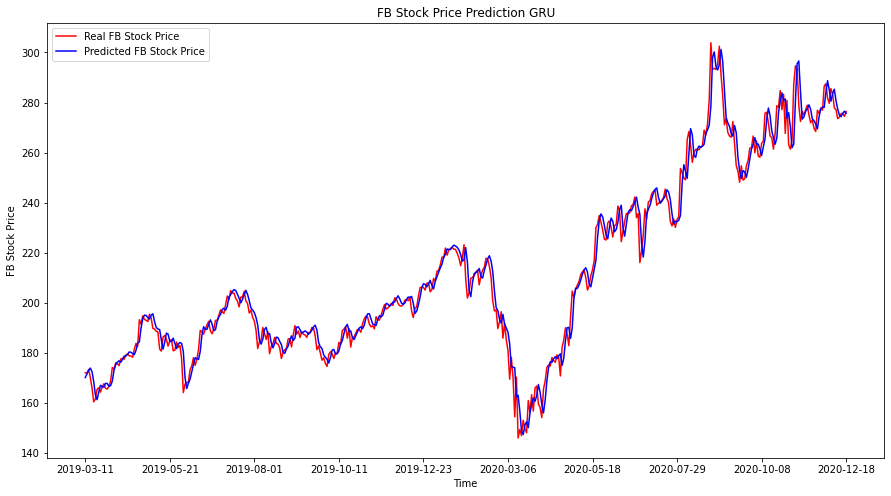

<Figure size 432x288 with 0 Axes>

In [ ]:

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real FB Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted FB Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('FB Stock Price Prediction GRU')
plt.xlabel('Time')
plt.ylabel('FB Stock Price')
plt.legend()
plt.show() 
plt.savefig("FB GRU")

In [ ]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

3.67904021087254

In [ ]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

5.294514952606184

Bi-LSTM

In [ ]:
np.random.seed(1)
model = Sequential()

model.add(Bidirectional(LSTM(units = 700, input_shape = (X_train.shape[1], 1))))
model.add(Dropout(0.1))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 3s 28ms/step - loss: 0.0602
Epoch 2/30
31/31 [==============================] - 1s 24ms/step - loss: 0.0046
Epoch 3/30
31/31 [==============================] - 1s 24ms/step - loss: 0.0024
Epoch 4/30
31/31 [==============================] - 1s 24ms/step - loss: 0.0026
Epoch 5/30
31/31 [==============================] - 1s 24ms/step - loss: 0.0020
Epoch 6/30
31/31 [==============================] - 1s 25ms/step - loss: 0.0015
Epoch 7/30
31/31 [==============================] - 1s 25ms/step - loss: 0.0014
Epoch 8/30
31/31 [==============================] - 1s 25ms/step - loss: 0.0015
Epoch 9/30
31/31 [==============================] - 1s 25ms/step - loss: 0.0015
Epoch 10/30
31/31 [==============================] - 1s 25ms/step - loss: 0.0017
Epoch 11/30
31/31 [==============================] - 1s 25ms/step - loss: 0.0013
Epoch 12/30
31/31 [==============================] - 1s 25ms/step - loss: 0.0012
Epoch 13/30
31/31 [==================

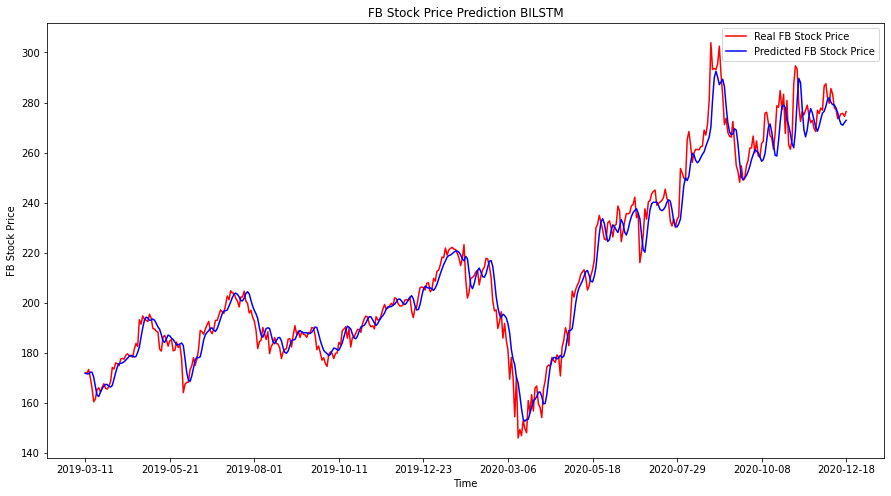

<Figure size 432x288 with 0 Axes>

In [ ]:

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real FB Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted FB Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('FB Stock Price Prediction BILSTM')
plt.xlabel('Time')
plt.ylabel('FB Stock Price')
plt.legend()
plt.show() 
plt.savefig("FB BILSTM")

In [ ]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

4.552015754066484

In [ ]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

6.371350028013741

Bi-GRU

In [ ]:
model = Sequential()

model.add(Bidirectional(GRU(units = 700, input_shape = (X_train.shape[1], 1))))
model.add(Dropout(0.1))


model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 4s 84ms/step - loss: 0.0570
Epoch 2/30
31/31 [==============================] - 3s 85ms/step - loss: 0.0034
Epoch 3/30
31/31 [==============================] - 3s 84ms/step - loss: 0.0020
Epoch 4/30
31/31 [==============================] - 3s 85ms/step - loss: 0.0015
Epoch 5/30
31/31 [==============================] - 3s 85ms/step - loss: 0.0013
Epoch 6/30
31/31 [==============================] - 3s 85ms/step - loss: 9.0979e-04
Epoch 7/30
31/31 [==============================] - 3s 85ms/step - loss: 0.0011
Epoch 8/30
31/31 [==============================] - 3s 96ms/step - loss: 9.4002e-04
Epoch 9/30
31/31 [==============================] - 3s 85ms/step - loss: 6.1846e-04
Epoch 10/30
31/31 [==============================] - 3s 87ms/step - loss: 9.8396e-04
Epoch 11/30
31/31 [==============================] - 3s 82ms/step - loss: 0.0010
Epoch 12/30
31/31 [==============================] - 3s 82ms/step - loss: 6.3372e-04
Epoch 13/30
31/31

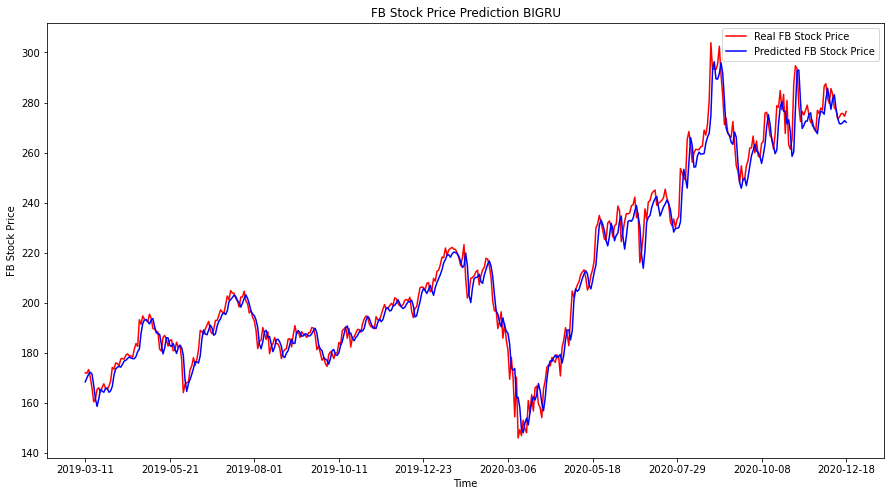

<Figure size 432x288 with 0 Axes>

In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real FB Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted FB Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('FB Stock Price Prediction BIGRU')
plt.xlabel('Time')
plt.ylabel('FB Stock Price')
plt.legend()
plt.show() 
plt.savefig("FB BIGRU")

In [ ]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

4.033431563270856

In [ ]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

5.600320218688257

Breaking Dataset to Improve Performance

In [ ]:
training_set = df.iloc[:, 4:5].values
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output




In [ ]:
X_train = []
y_train = []
for i in range(60, 351):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

for i in range(501, 852):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

for i in range(1002, 1353):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],  X_train.shape[1], 1))
X_train.shape

(993, 60, 1)

In [ ]:

inputs = df.iloc[:, 4:5].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)




(1503, 1)


In [ ]:
X_test = []
y_test = []
for i in range(351, 501):
    X_test.append(inputs[i-60:i, 0])
    y_test.append(df.iloc[i, 4:5].values)

for i in range(852, 1002):
    X_test.append(inputs[i-60:i, 0])
    y_test.append(df.iloc[i, 4:5].values)

for i in range(1353, 1503):
    X_test.append(inputs[i-60:i, 0])
    y_test.append(df.iloc[i, 4:5].values)

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)

(450, 60, 1)


In [ ]:
np.random.seed(1)

model = Sequential()

model.add(GRU(units = 700, input_shape = (X_train.shape[1], 1))) 
model.add(Dropout(0.2))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
32/32 [==============================] - 2s 13ms/step - loss: 0.0263
Epoch 2/30
32/32 [==============================] - 0s 11ms/step - loss: 4.9216e-04
Epoch 3/30
32/32 [==============================] - 0s 11ms/step - loss: 5.1595e-04
Epoch 4/30
32/32 [==============================] - 0s 11ms/step - loss: 4.2150e-04
Epoch 5/30
32/32 [==============================] - 0s 11ms/step - loss: 8.0167e-04
Epoch 6/30
32/32 [==============================] - 0s 11ms/step - loss: 3.7842e-04
Epoch 7/30
32/32 [==============================] - 0s 11ms/step - loss: 3.6938e-04
Epoch 8/30
32/32 [==============================] - 0s 11ms/step - loss: 4.6233e-04
Epoch 9/30
32/32 [==============================] - 0s 11ms/step - loss: 7.4184e-04
Epoch 10/30
32/32 [==============================] - 0s 11ms/step - loss: 3.7352e-04
Epoch 11/30
32/32 [==============================] - 0s 11ms/step - loss: 4.0734e-04
Epoch 12/30
32/32 [==============================] - 0s 11ms/step - loss: 3.38

In [ ]:

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


In [ ]:
abse = mean_absolute_error(predicted_stock_price, y_test)

In [ ]:
abse

4.798862377161458

In [ ]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y_test))
rmse

6.795892681369122

In [ ]:
x1 = df.loc[351:500 , "Date"]
x2 = df.loc[852:1001 , "Date"]
x3 = df.loc[1353: , "Date"]

In [ ]:
x = pd.concat([x1,x2,x3], axis =0)

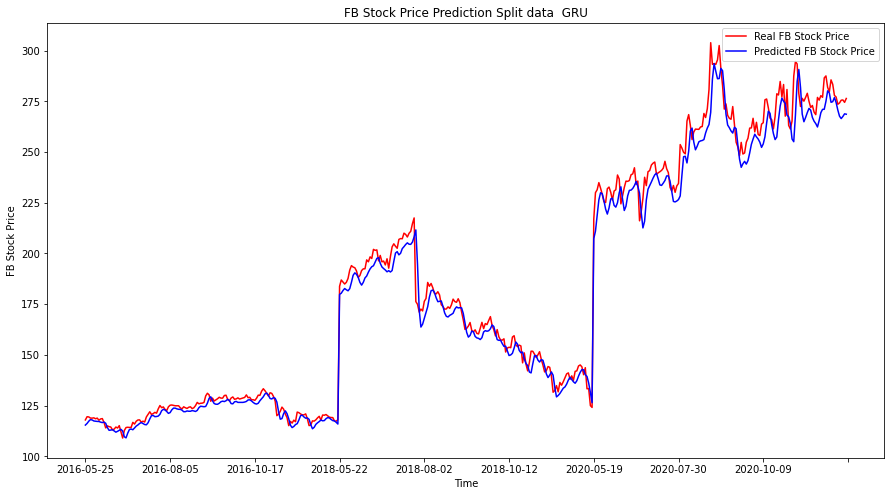

<Figure size 432x288 with 0 Axes>

In [ ]:

# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y_test, c= "red", label = "Real FB Stock Price")
plt.plot(x,predicted_stock_price, color = "blue", label = "Predicted FB Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('FB Stock Price Prediction Split data  GRU')
plt.xlabel('Time')
plt.ylabel('FB Stock Price')
plt.legend()
plt.show() 
plt.savefig("FB Split data GRU")